In [ ]:
"""
Notebook for training the transformer model for the flow around a cylinder system.
=====
Distributed by: Notre Dame SCAI Lab (MIT Liscense)
- Associated publication:
url: https://arxiv.org/abs/2010.03957
doi: 
github: https://github.com/zabaras/transformer-physx
=====
"""
!nvidia-smi

Thu Jul 29 01:43:48 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   55C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Environment Setup

Use pip to install from [PyPI](https://pypi.org/project/trphysx/).

In [ ]:
!pip install trphysx==0.0.7

     |████████████████████████████████| 137 kB 32.3 MB/s 


Mount google drive and create a folder to work in.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
%cd /content/gdrive/MyDrive/
% mkdir -p transformer_physx/cylinder
% cd transformer_physx/cylinder

/content/gdrive/MyDrive
/content/gdrive/MyDrive/transformer_physx/cylinder


## Downloading Data and Models

Now lets download the training and validation data for the cylinder system. This will eventually be update to zenodo repo.

In [ ]:
!mkdir data

mkdir: cannot create directory ‘data’: File exists


**WARNING: Training datafile is 1.3Gb! Validation is 0.35Gb!** These will be stored in your Google drive!

Because this is a big datafile, we will use gdown to instead of wget because of virus warning from google drive.

In [ ]:
!pip install gdown
import gdown
import os
if not os.path.exists("./data/cylinder_training.hdf5"):
  gdown.download("https://drive.google.com/uc?id=1i6ObgR4GsSMRBJ16rdMvexgU2egKYT3v", "./data/cylinder_training.hdf5", quiet=False)
if not os.path.exists("./data/cylinder_valid.hdf5"):
  gdown.download("https://drive.google.com/uc?id=10I_uqaKgq82IxTKiRnaJ39Ajpe4e8Rws", "./data/cylinder_valid.hdf5", quiet=False)
# !wget -O ./data/cylinder_training.hdf5 "https://drive.google.com/uc?id=1i6ObgR4GsSMRBJ16rdMvexgU2egKYT3v"
# !wget -O ./data/cylinder_valid.hdf5 "https://drive.google.com/uc?id=10I_uqaKgq82IxTKiRnaJ39Ajpe4e8Rws"

Next lets download a pretrained embedding model. You can replace with with your own if you want.

In [ ]:
!wget -O ./embedding_cylinder300.pth "https://drive.google.com/uc?export=download&id=14ECLtbKjj-q1k3wrujGIm_fGym6r8y7i"

--2021-07-29 01:49:27--  https://drive.google.com/uc?export=download&id=14ECLtbKjj-q1k3wrujGIm_fGym6r8y7i
Resolving drive.google.com (drive.google.com)... 142.250.73.206, 2607:f8b0:4004:829::200e
Connecting to drive.google.com (drive.google.com)|142.250.73.206|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0k-0o-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/gobjqnouh3rtobrha1gfbu4j0hrt8a0q/1627523325000/01559412990587423567/*/14ECLtbKjj-q1k3wrujGIm_fGym6r8y7i?e=download [following]
--2021-07-29 01:49:28--  https://doc-0k-0o-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/gobjqnouh3rtobrha1gfbu4j0hrt8a0q/1627523325000/01559412990587423567/*/14ECLtbKjj-q1k3wrujGIm_fGym6r8y7i?e=download
Resolving doc-0k-0o-docs.googleusercontent.com (doc-0k-0o-docs.googleusercontent.com)... 142.250.73.193, 2607:f8b0:4004:829::2001
Connecting to doc-0k-0o-docs.googleusercontent.com (doc-0k-0o-docs.

# Transformer-PhysX Cylinder System

Now lets actually run some Python, set up imports. Note that since the Lorenz system is built into transformer-physx package we will use auto modules to load the specific classes for this numerical example.

In [ ]:
import sys
import logging
import torch
from trphysx.config import HfArgumentParser
from trphysx.config.args import ModelArguments, TrainingArguments, DataArguments, ArgUtils
from trphysx.config import AutoPhysConfig
from trphysx.transformer import PhysformerTrain, PhysformerGPT2
from trphysx.embedding import AutoEmbeddingModel
from trphysx.viz import AutoViz
from trphysx.data_utils import AutoDataset
from trphysx.utils.trainer import Trainer

logger = logging.getLogger(__name__)

Set training arguments. For running this outside of a notebook, you would use "sys.argv" and then no arguement when you parse args into dataclasses. This would allow the use of command line parameters as well. See [example script](https://github.com/zabaras/transformer-physx/blob/main/examples/cylinder/train_cylinder_transformer.py) on the github repo.

In [ ]:
argv = []
argv = argv + ["--init_name", "cylinder"]
argv = argv + ["--embedding_file_or_path", "./embedding_cylinder300.pth"]
argv = argv + ["--training_h5_file","./data/cylinder_training.hdf5"]
argv = argv + ["--eval_h5_file","./data/cylinder_valid.hdf5"]
argv = argv + ["--train_batch_size", "4"]
argv = argv + ["--n_train", "27"]
argv = argv + ["--n_eval", "6"]
argv = argv + ["--stride", "4"]
argv = argv + ["--max_grad_norm", "0.01"]
argv = argv + ["--save_steps", "25"]

In [ ]:
# Parse arguments using the hugging face argument parser
parser = HfArgumentParser((ModelArguments, DataArguments, TrainingArguments))
model_args, data_args, training_args = parser.parse_args_into_dataclasses(argv)

# Setup logging
logging.basicConfig(
    format="%(asctime)s - %(levelname)s - %(name)s -   %(message)s",
    datefmt="%m/%d/%Y %H:%M:%S",
    level=logging.INFO if training_args.local_rank in [-1, 0] else logging.WARN)
# Configure arguments after intialization 
model_args, data_args, training_args = ArgUtils.config(model_args, data_args, training_args)

# Load model configuration
config = AutoPhysConfig.load_config(model_args.config_name)

07/29/2021 01:50:20 - INFO - root -   Using a single GPU for training.


## Initalizing Models

In [ ]:
# Load embedding model
embedding_model = AutoEmbeddingModel.load_model(
    model_args.embedding_name, 
    config, 
    model_args.embedding_file_or_path).to(training_args.src_device)

# Load visualization utility class
viz = AutoViz.load_viz(model_args.viz_name, plot_dir=training_args.plot_dir)

# Init transformer model
transformer = PhysformerGPT2(config, model_args.model_name)
model  = PhysformerTrain(config, transformer)
if(training_args.epoch_start > 0):
    model.load_model(training_args.ckpt_dir, epoch=training_args.epoch_start)
if(model_args.transformer_file_or_path):
    model.load_model(model_args.transformer_file_or_path)

07/29/2021 01:52:06 - INFO - trphysx.embedding.embedding_cylinder -   Number of embedding parameters: 262535
07/29/2021 01:52:06 - INFO - trphysx.embedding.embedding_model -   Loading embedding model from file: ./embedding_cylinder300.pth
07/29/2021 01:52:06 - INFO - trphysx.transformer.phys_transformer_gpt2 -   Number of parameters: 1208448


## Creating Datasets

Next create the training and validation datasets. This will probably take a little bit. We need to compute the embedded representations for the transformer for each example. Fortunately, assuming your embedding model has not changed or block size, the dataset will be locally cached allowing for fast reloading in the future. Use the "overwrite_cache" argument to force a new dataset creation.

In [ ]:
# Initialize training and validation datasets
training_data = AutoDataset.create_dataset(
      model_args.model_name,
      embedding_model, 
      data_args.training_h5_file, 
      block_size=config.n_ctx, 
      stride=data_args.stride,
      ndata=data_args.n_train, 
      overwrite_cache=data_args.overwrite_cache)

eval_data = AutoDataset.create_dataset(
      model_args.model_name,
      embedding_model, 
      data_args.eval_h5_file, 
      block_size=256,
      stride=1024,
      ndata=data_args.n_eval, 
      eval = True,
      overwrite_cache=data_args.overwrite_cache)

07/29/2021 01:52:08 - INFO - filelock -   Lock 139952560939856 acquired on ./data/cached27_CylinderEmbedding_16_cylinder_training.hdf5.lock
07/29/2021 01:52:08 - INFO - trphysx.data_utils.dataset_phys -   Creating features from dataset file at ./data
07/29/2021 01:52:54 - INFO - trphysx.data_utils.dataset_cylinder -   Collected 27 time-series from hdf5 file. Total of 2619 time-series.
07/29/2021 01:52:57 - INFO - trphysx.data_utils.dataset_phys -   Saving features into cached file ./data/cached27_CylinderEmbedding_16_cylinder_training.hdf5 [took 2.718 s]
07/29/2021 01:52:57 - INFO - filelock -   Lock 139952560939856 released on ./data/cached27_CylinderEmbedding_16_cylinder_training.hdf5.lock
07/29/2021 01:52:57 - INFO - filelock -   Lock 139952630544528 acquired on ./data/cached6_CylinderEmbedding_256_cylinder_valid.hdf5.lock
07/29/2021 01:52:57 - INFO - trphysx.data_utils.dataset_phys -   Creating features from dataset file at ./data
07/29/2021 01:53:13 - INFO - trphysx.data_utils.dat

Initialize the optimizer and scheduler.

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=training_args.lr, weight_decay=1e-10)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, 14, 2, eta_min=1e-9)

## Training the Transformer

Create training class and train.

In [ ]:
trainer = Trainer(
        model, 
        training_args, 
        (optimizer, scheduler), 
        train_dataset = training_data, 
        eval_dataset = eval_data, 
        embedding_model = embedding_model,
        viz=viz)
    
trainer.train()

07/29/2021 01:54:51 - INFO - trphysx.utils.trainer -   Current Learning rate: 0.00095
07/29/2021 01:54:51 - INFO - trphysx.utils.trainer -   Epoch 1: Training loss 0.32742
07/29/2021 01:54:51 - INFO - trphysx.utils.trainer -   Current Learning rate: 0.00095
07/29/2021 01:54:51 - INFO - trphysx.utils.trainer -   Evaluating...
07/29/2021 01:55:10 - INFO - trphysx.utils.trainer -   Eval embedding error: 3.95, State error: 0.08
07/29/2021 01:55:10 - INFO - trphysx.utils.trainer -   Checkpointing model, optimizer and scheduler.
07/29/2021 01:55:27 - INFO - trphysx.utils.trainer -   Current Learning rate: 0.00089
07/29/2021 01:55:27 - INFO - trphysx.utils.trainer -   Epoch 2: Training loss 0.01990
07/29/2021 01:55:42 - INFO - trphysx.utils.trainer -   Current Learning rate: 0.00081
07/29/2021 01:55:42 - INFO - trphysx.utils.trainer -   Epoch 3: Training loss 0.01056
07/29/2021 01:55:58 - INFO - trphysx.utils.trainer -   Current Learning rate: 0.00072
07/29/2021 01:55:58 - INFO - trphysx.util

## Visualization of Results

We will just embed a few of the test prediction for several epochs. More can be viewed in the outputs folder.

data  embedding_cylinder300.pth  outputs

Validation prediction for epoch: 1
x-velocity


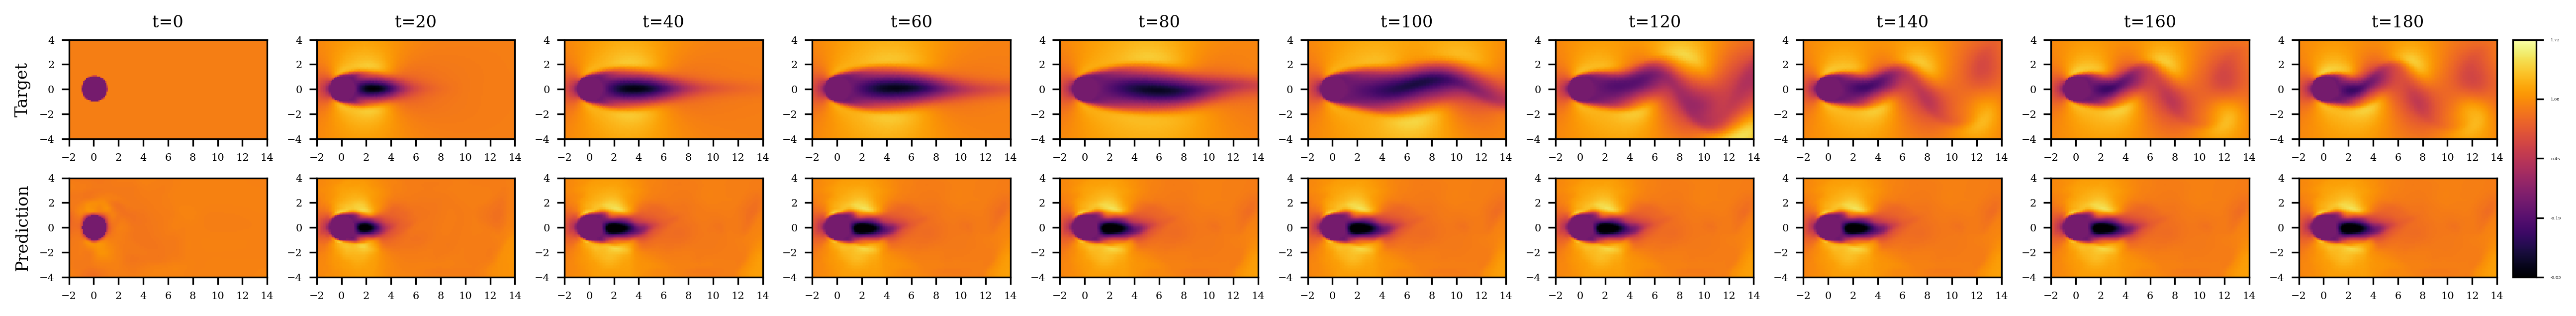

y-velocity


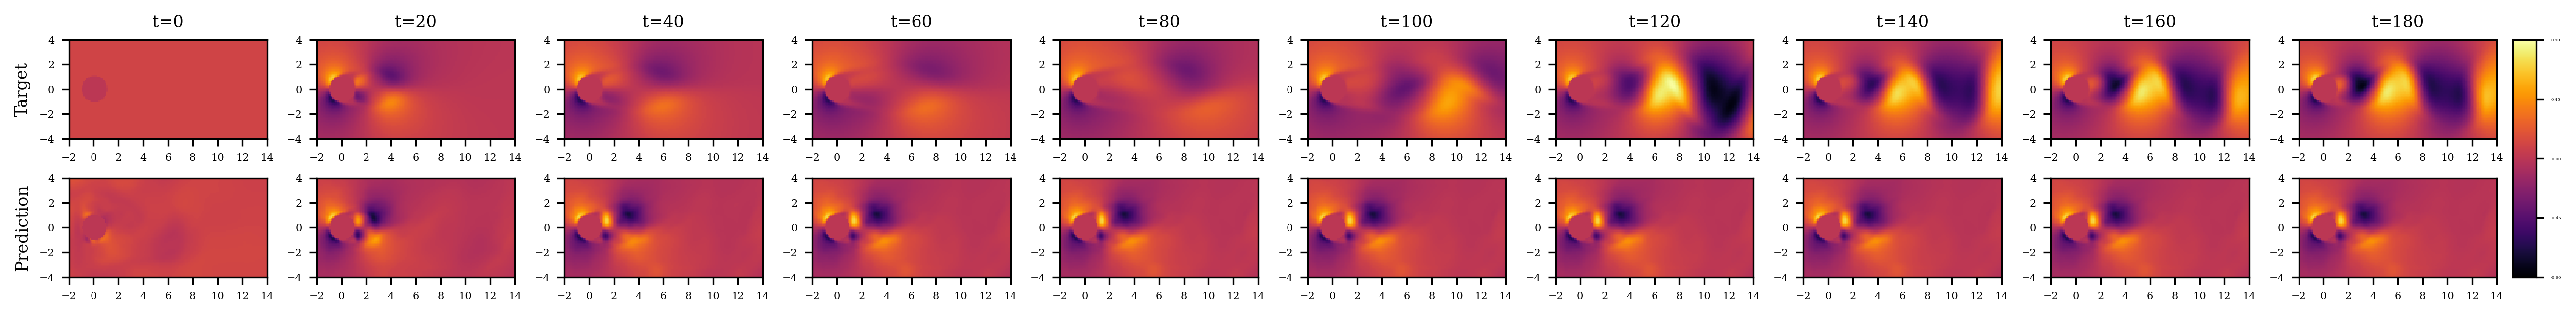


Validation prediction for epoch: 50
x-velocity


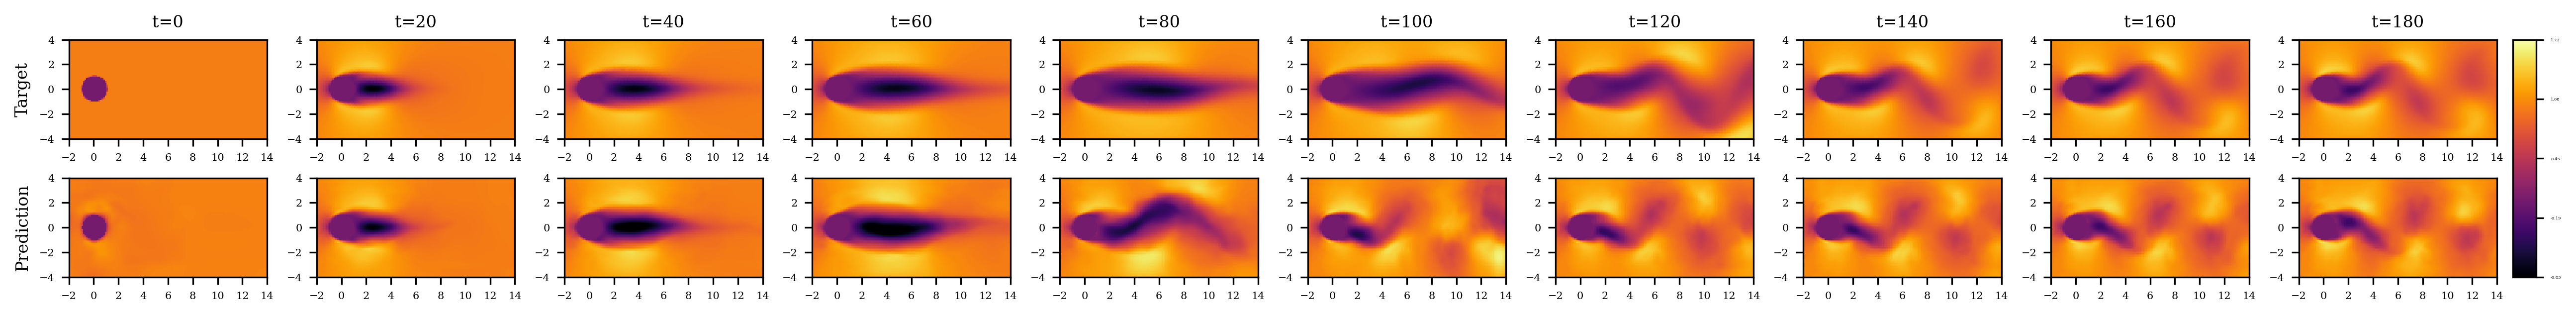

y-velocity


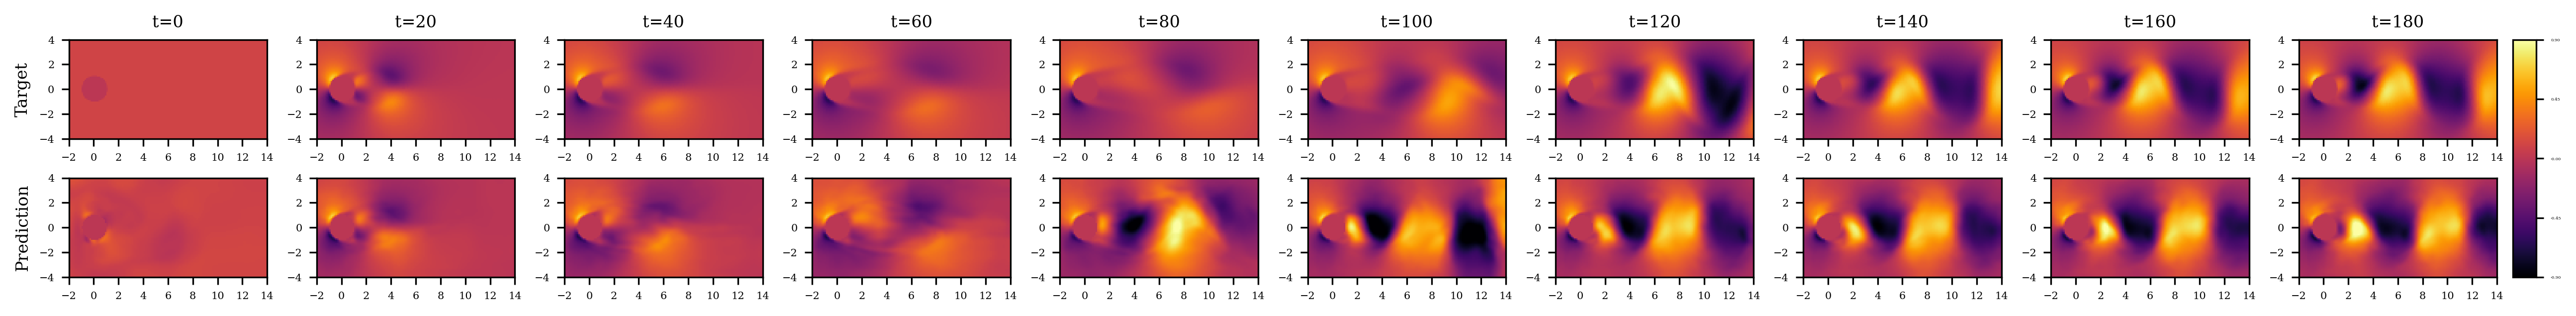


Validation prediction for epoch: 100
x-velocity


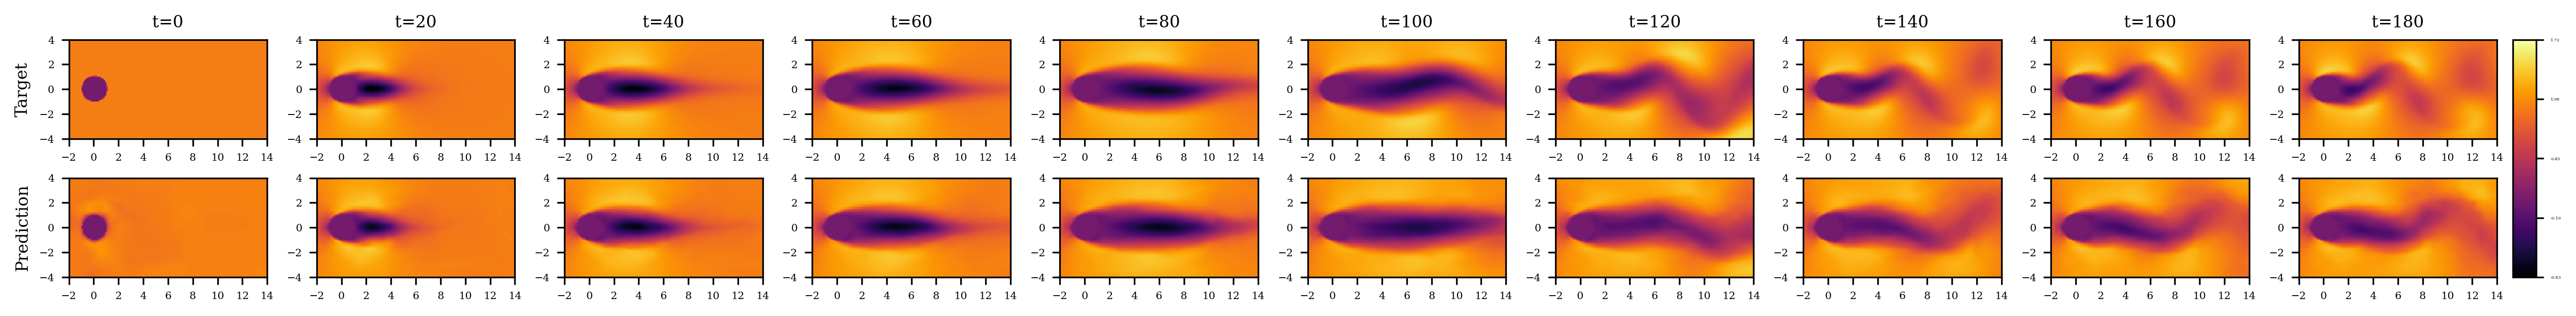

y-velocity


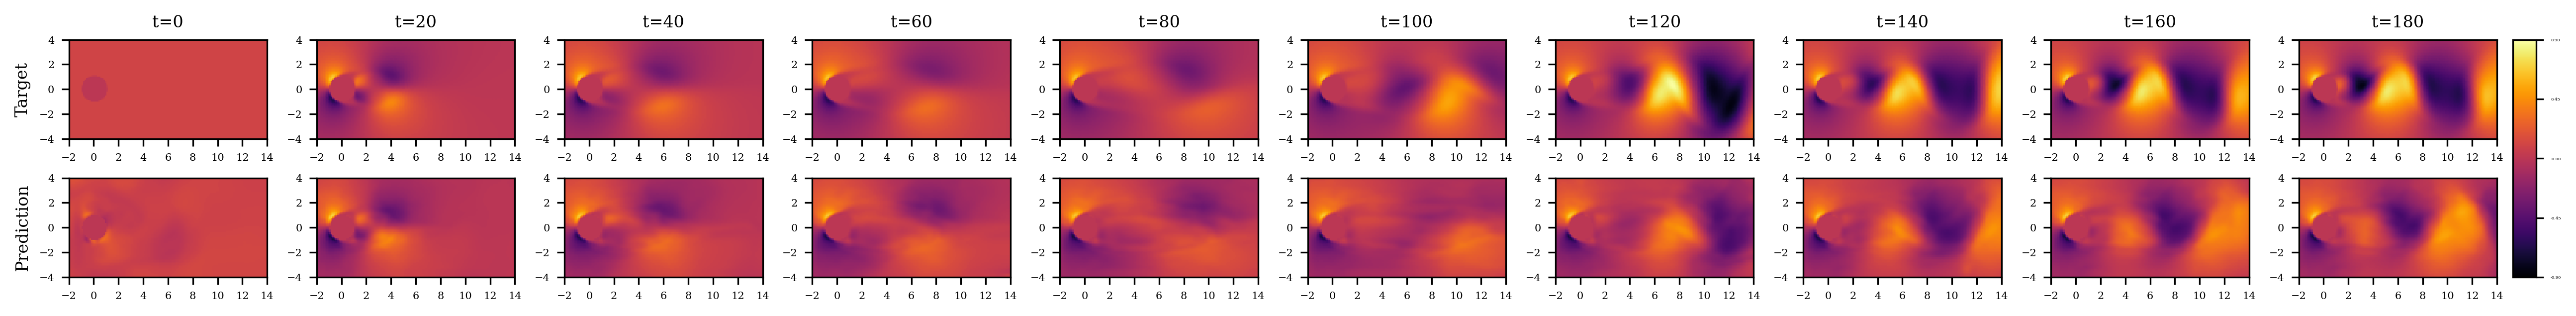


Validation prediction for epoch: 150
x-velocity


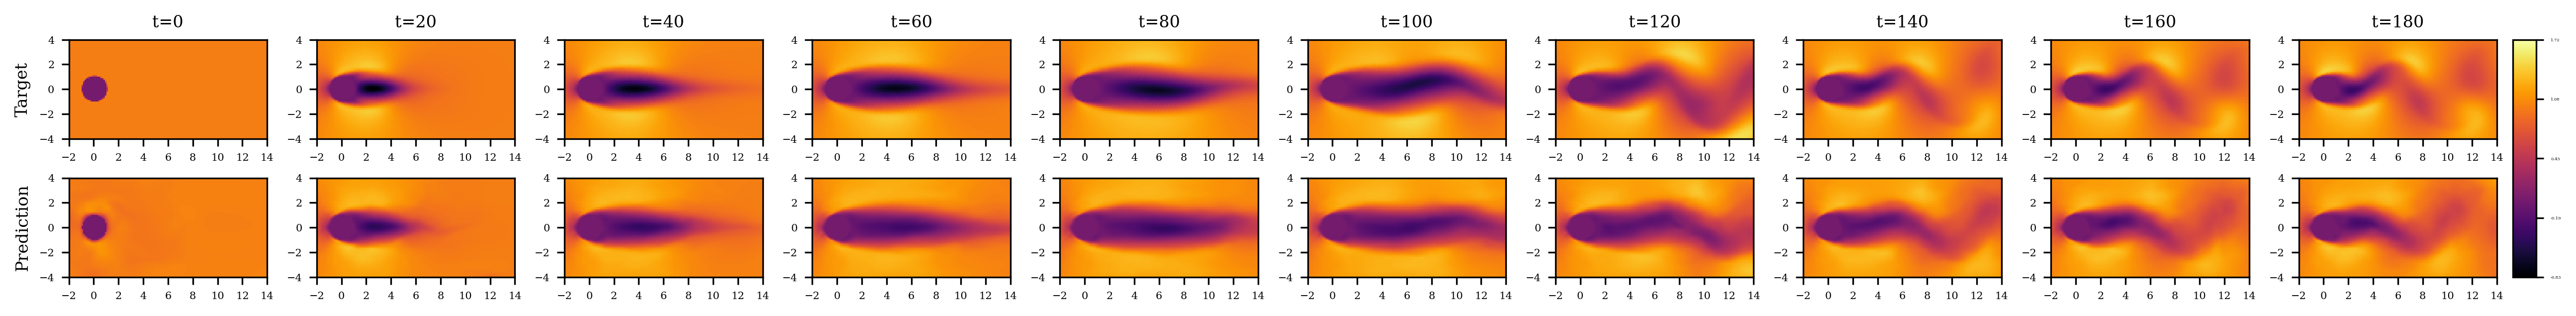

y-velocity


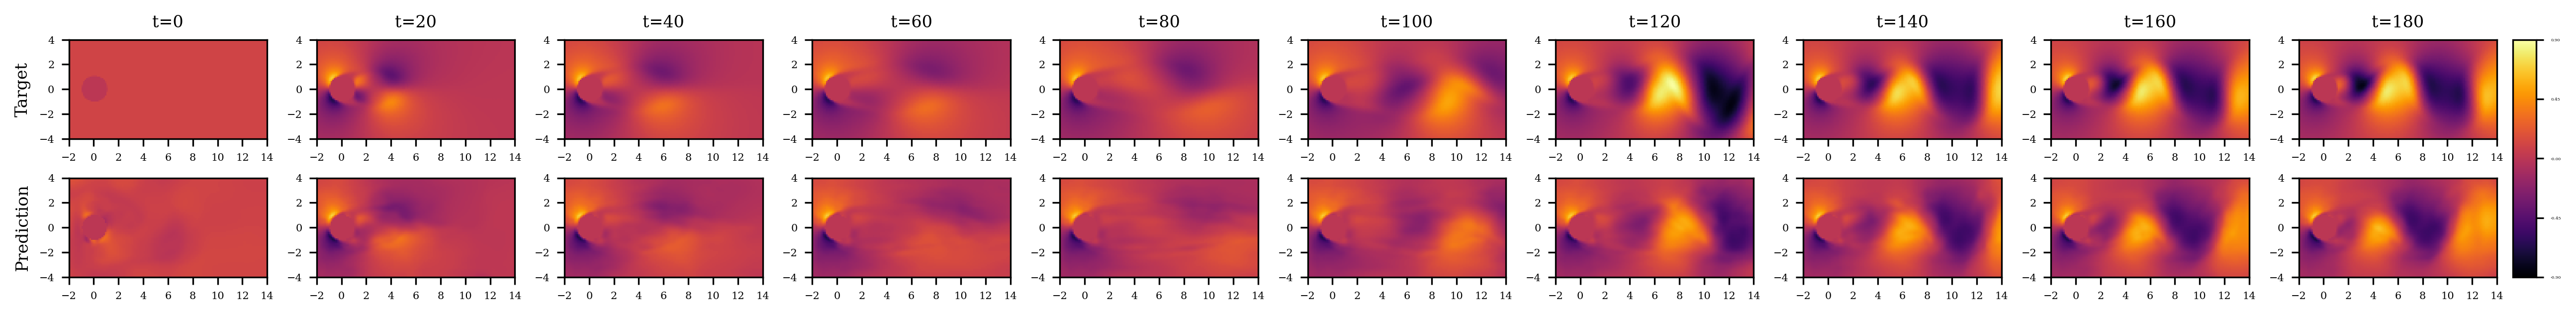


Validation prediction for epoch: 200
x-velocity


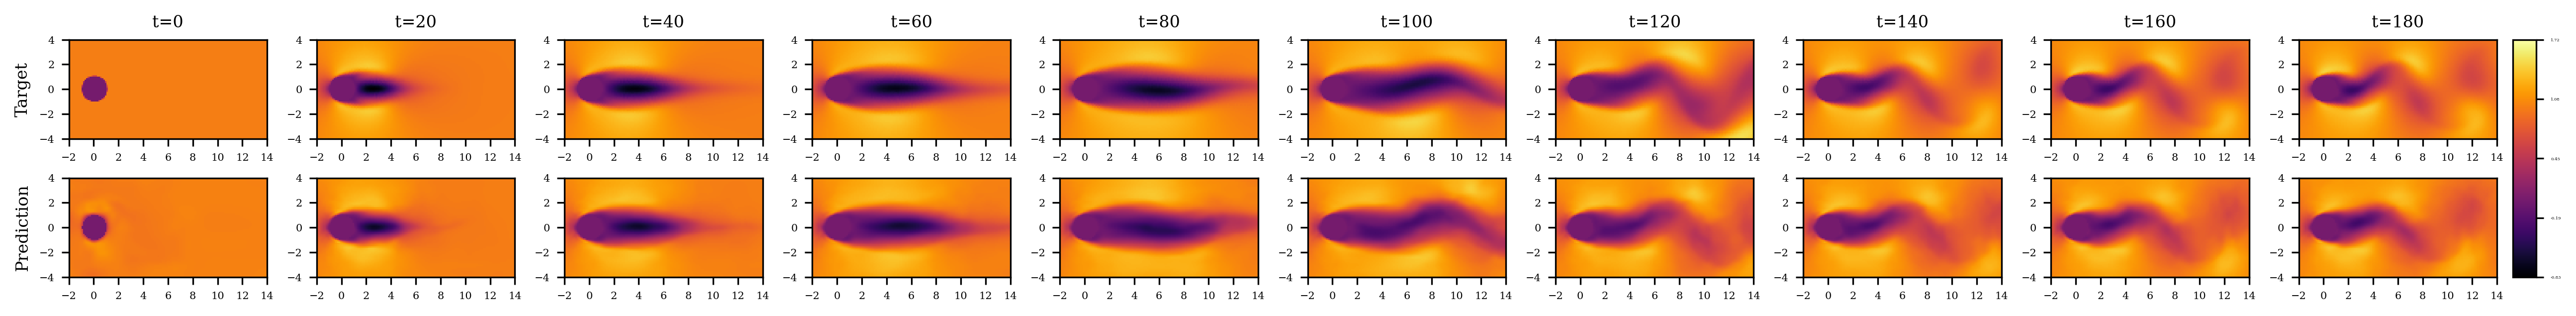

y-velocity


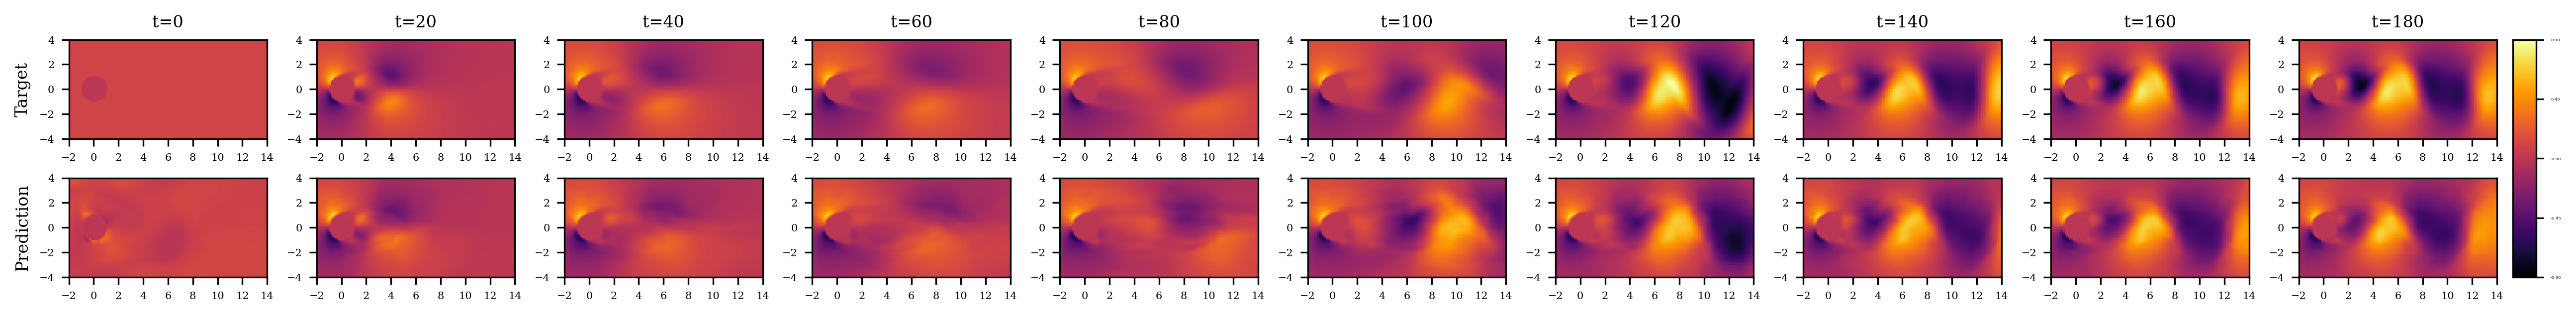

In [ ]:
from IPython.display import Image, display
!ls
for epoch in [1, 50, 100, 150, 200]:
  print('\nValidation prediction for epoch: {:d}'.format(epoch))
  print('x-velocity')
  file_path = './outputs/transformer_cylinder/ntrain27_epochs200_batch4/viz/cylinderuxPred0_{:d}.png'.format(epoch)
  display(Image(file_path, width=1000, height=100))
  print('y-velocity')
  file_path = './outputs/transformer_cylinder/ntrain27_epochs200_batch4/viz/cylinderuyPred0_{:d}.png'.format(epoch)
  display(Image(file_path, width=1000, height=100))